# Setup

In [1]:
# imports 
import pandas as pd
import opendatasets as od
import time
import datetime
import torch.nn as nn
from torchsummary import summary
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.pyplot import xticks

In [2]:
dataset_url = 'https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction'
# od.download(dataset_url)

In [3]:
df = pd.read_csv('./NYCTaxiFares_small.csv')
df['pickup_datetime'].max()

'2010-04-25 03:59:42 UTC'

# Pre-processing

In [4]:
df.drop(labels=['fare_class'], axis=1, inplace=True)

In [5]:
## Running this cell is really fucking slow, but it works.
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

def havardsine_distance(lat1, long1, lat2, long2):
    r = 6371

    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)

    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(long2 - long1)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = (r * c) # convert to kilometer
    return d

df['dist_km'] = df.apply(lambda row: havardsine_distance(row.pickup_latitude, row.pickup_longitude, row.dropoff_latitude, row.dropoff_longitude), axis=1)

airport_cords = [
    [40.691547, -74.180202], # NEWARK
    [40.773281, -73.869845], # LAGUARDIA
]

# When I wrote this code, only God and I knew what was going on. Today, only God knows.
def close_to_airport(values):
    pickup_latitude = values['pickup_latitude']
    pickup_longitude = values['pickup_longitude']
    dropoff_latitude = values['dropoff_latitude']
    dropoff_longitude = values['dropoff_longitude']

    # JFK is special, it needs a bigger radius
    jfkpickup = havardsine_distance(pickup_latitude, pickup_longitude, 40.645042, -73.786928) <= 1.00
    jfkdropoff = havardsine_distance(dropoff_latitude, dropoff_longitude, 40.645042, -73.786928) <= 1.00

    # Newark is a small airport but their parking log is BIG.
    newarkpickup = havardsine_distance(pickup_latitude, pickup_longitude, 40.691547, -74.180202) <= 1.00
    newarkdropoff = havardsine_distance(dropoff_latitude, dropoff_longitude, 40.691547, -74.180202) <= 1.00

    # Third largest, it's an abstract airport with a stretched out U shaped parking place
    # LaGuardia
    laguardiapickup = havardsine_distance(pickup_latitude, pickup_longitude, 40.773855, -73.871712) <= 0.50
    laguardiadropoff = havardsine_distance(dropoff_latitude, dropoff_longitude, 40.773855, -73.871712) <= 0.50

    return 1 if jfkpickup or jfkdropoff or newarkpickup or newarkdropoff or laguardiapickup or laguardiadropoff else 0

df['is_by_airport'] = df.apply(close_to_airport, axis=1)

In [6]:
my_time = df['pickup_datetime'][0]

In [7]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour'] < 12, 0, 1)

In [8]:
df['Weekday'] = pd.to_numeric(df['EDTdate'].dt.strftime("%w")) # an int between 0 - 6, representing the weekdays
df['Month'] = pd.to_numeric(df['EDTdate'].dt.strftime("%m")) # an int between 0 - 6, representing the weekdays

#Formatting this correctly, we can use the dates to get the historical weather data for the dates
df['FullDate'] = df['EDTdate'].dt.strftime('%x')
#print(df['FullDate'].min())
#print(df['FullDate'].max())
print(df['FullDate'].unique())

['04/19/10' '04/17/10' '04/11/10' '04/16/10' '04/22/10' '04/23/10'
 '04/15/10' '04/20/10' '04/21/10' '04/14/10' '04/13/10' '04/12/10'
 '04/24/10' '04/18/10']


In [9]:
# lets have some weather-y fuuuuuuuuuuuun-fuuuuuun-function
# see this for doc https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf
weather_data = pd.read_csv('nyc-weather-data.csv')
weather_labels = ['SNWD', 'SNOW', 'AWND'] #snow depth, snowfall, wind speed
for index, item in enumerate(weather_labels):
    weather_data.loc[weather_data[item] <= -9999, item] = 0 # -9999 means that there is no data

# df['dist_km'] = df.apply(lambda row: havardsine_distance(row.pickup_latitude, row.pickup_longitude, row.dropoff_latitude, row.dropoff_longitude), axis=1)

weather_data['DATE'] = weather_data.apply(lambda row: datetime.datetime.strptime(str(row.DATE), '%Y%m%d').strftime('%m/%d/%y'), axis=1)
weather_data = weather_data[['DATE','PRCP','SNWD','SNOW','TMAX','TMIN','AWND']]

weather_data['TMIN'] = (weather_data['TMIN'] / 10) # the API returns degrees in an old format. We therefore convert the value to a tenth of its own form. Check the docu for this.
weather_data['TMAX'] = (weather_data['TMAX'] / 10) # min temperature and max temperateure
weather_data['PRCP'] = weather_data['PRCP'] / 10   # precipitation

weather_data['AWND'] = weather_data['AWND'] / 2.237 # meters per second

df.rename(columns={'FullDate':'DATE'}, inplace=True)

merged_df = pd.merge(df, weather_data, how="left",on="DATE")

In [10]:
# network_data = merged_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'dist_km', 'passenger_count', 'Hour', 'AMorPM', 'Weekday', 'Month', 'fare_amount']]#, 'is_by_airport','PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN', 'AWND']]
#
# #print(network_data)
#
# prediction = network_data['fare_amount']
#
# # network_data.drop('fare_amount', axis=1)
# X = network_data.drop('fare_amount', axis=1)
#
# #y = prediction.values.reshape(-1,1)
# y=prediction
#
# # scaler = StandardScaler()
# #
# # scaler.fit_transform(train_X, test_X)

In [11]:
merged_df

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,is_by_airport,EDTdate,...,AMorPM,Weekday,Month,DATE,PRCP,SNWD,SNOW,TMAX,TMIN,AWND
0,2010-04-19 08:17:56+00:00,6.5,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,0,2010-04-19 04:17:56+00:00,...,0,1,4,04/19/10,0.0,0,0,17.2,7.8,13.857845
1,2010-04-17 15:43:53+00:00,6.9,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,0,2010-04-17 11:43:53+00:00,...,0,6,4,04/17/10,0.3,0,0,12.2,7.8,13.410818
2,2010-04-17 11:23:26+00:00,10.1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,0,2010-04-17 07:23:26+00:00,...,0,6,4,04/17/10,0.3,0,0,12.2,7.8,13.410818
3,2010-04-11 21:25:03+00:00,8.9,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,0,2010-04-11 17:25:03+00:00,...,1,0,4,04/11/10,0.0,0,0,24.4,11.1,13.410818
4,2010-04-17 02:19:01+00:00,19.7,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,0,2010-04-16 22:19:01+00:00,...,1,5,4,04/16/10,7.9,0,0,13.9,7.8,14.751900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,2010-04-18 14:33:03+00:00,15.3,-73.955857,40.784590,-73.981941,40.736789,1,5.751348,0,2010-04-18 10:33:03+00:00,...,0,0,4,04/18/10,0.0,0,0,13.9,5.6,14.304873
119996,2010-04-23 10:27:48+00:00,15.3,-73.996329,40.772727,-74.049890,40.740413,1,5.767444,0,2010-04-23 06:27:48+00:00,...,0,5,4,04/23/10,0.0,0,0,20.0,6.7,12.963791
119997,2010-04-18 18:50:40+00:00,12.5,-73.988574,40.749772,-74.011541,40.707799,3,5.052523,0,2010-04-18 14:50:40+00:00,...,1,0,4,04/18/10,0.0,0,0,13.9,5.6,14.304873
119998,2010-04-13 08:14:44+00:00,4.9,-74.004449,40.724529,-73.992697,40.730765,1,1.208923,0,2010-04-13 04:14:44+00:00,...,0,2,4,04/13/10,0.0,0,0,13.3,8.3,9.834600


# EDA

In [12]:
merged_df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
is_by_airport                      int64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AMorPM                             int64
Weekday                            int64
Month                              int64
DATE                              object
PRCP                             float64
SNWD                               int64
SNOW                               int64
TMAX                             float64
TMIN                             float64
AWND                             float64
dtype: object

In [13]:
merged_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,is_by_airport,Hour,AMorPM,Weekday,Month,PRCP,SNWD,SNOW,TMAX,TMIN,AWND
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.0,120000.000000,120000.0,120000.0,120000.000000,120000.000000,120000.000000
mean,10.040326,-73.976626,40.751443,-73.974501,40.751695,1.347167,3.322160,0.032442,11.920042,0.531642,3.207108,4.0,0.741308,0.0,0.0,18.541002,8.677797,12.350287
std,7.500134,0.031497,0.025821,0.032419,0.030279,0.759263,3.337004,0.177171,5.964038,0.499000,1.950742,0.0,2.171493,0.0,0.0,3.708399,1.745160,1.649492
min,2.500000,-74.465447,40.121653,-74.443323,40.164927,1.000000,0.010208,0.000000,0.000000,0.000000,0.000000,4.0,0.000000,0.0,0.0,12.200000,5.600000,9.834600
25%,5.700000,-73.992386,40.736594,-73.991478,40.735914,1.000000,1.316428,0.000000,7.000000,0.000000,2.000000,4.0,0.000000,0.0,0.0,13.900000,7.800000,10.728654
50%,7.700000,-73.982084,40.753661,-73.980411,40.754441,1.000000,2.237084,0.000000,12.000000,1.000000,3.000000,4.0,0.000000,0.0,0.0,20.000000,7.800000,12.963791
75%,11.300000,-73.968710,40.768020,-73.965500,40.768880,1.000000,4.034564,0.000000,17.000000,1.000000,5.000000,4.0,0.000000,0.0,0.0,21.100000,10.600000,13.410818
max,49.900000,-73.311845,40.981292,-73.496140,40.993498,5.000000,28.846365,1.000000,23.000000,1.000000,6.000000,4.0,7.900000,0.0,0.0,24.400000,11.700000,14.751900


Text(0.5, 0, 'Distance (km)')

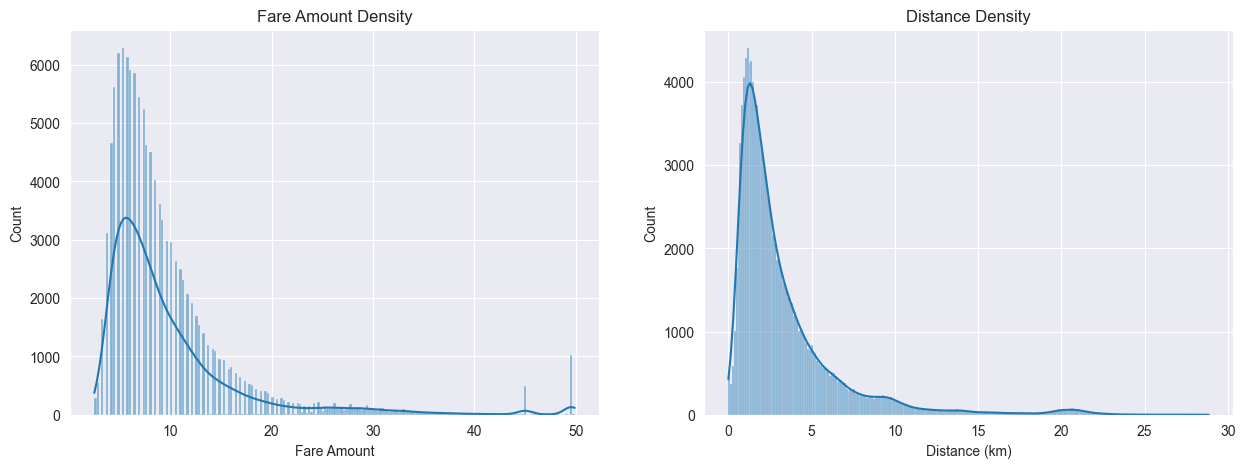

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.histplot(merged_df['fare_amount'], ax=axs[0], kde=True)
axs[0].set_title("Fare Amount Density")
axs[0].set_xlabel("Fare Amount")

sns.histplot(merged_df['dist_km'], ax=axs[1], kde=True)
axs[1].set_title("Distance Density")
axs[1].set_xlabel("Distance (km)")

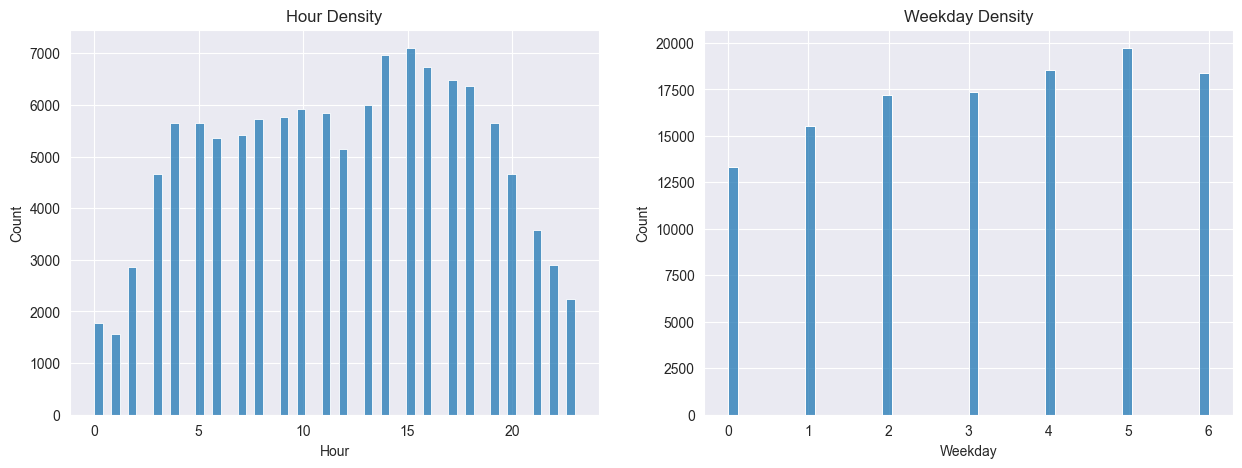

In [15]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.histplot(merged_df, x='Hour', ax=axs[0])
axs[0].set_title('Hour Density')
axs[0].set_xlabel('Hour')

sns.histplot(merged_df, x='Weekday', ax=axs[1])
axs[1].set_title('Weekday Density')
axs[1].set_xlabel('Weekday')

plt.show()

In [16]:
"""
PRCP - Precipitation
SNOW - Snowfall - All 0?
SNWD - Snow depth - All 0?
TMAX - Max temperature
TMIN - Min temperature
AWND - Average wind speed
"""
# fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20,20))

# sns.histplot(merged_df['SNOW'], ax=axs[0][0])
# axs[0][0].set_title("SNOW distribution")
# axs[0][0].set_xlabel("SNOW")

# sns.histplot(merged_df['SNWD'], ax=axs[0][1])
# axs[0][1].set_title("SNWD distribution")
# axs[0][1].set_xlabel("SNWD")

# sns.histplot(merged_df['PRCP'], ax=axs[1][0])
# axs[1][0].set_title("PRCP")
# axs[1][0].set_xlabel("PRCP")

# sns.histplot(merged_df["AWND"], ax=axs[1][1])
# axs[1][1].set_title("AWND")
# axs[1][1].set_xlabel("AWND")

# sns.histplot(merged_df["TMAX"], ax=axs[2][0])
# axs[2][0].set_title("TMAX")
# axs[2][0].set_xlabel("TMAX")

# sns.histplot(merged_df["TMIN"], ax=axs[2][1])
# axs[2][1].set_title("TMIN")
# axs[2][1].set_xlabel("TMIN")


'\nPRCP - Precipitation\nSNOW - Snowfall - All 0?\nSNWD - Snow depth - All 0?\nTMAX - Max temperature\nTMIN - Min temperature\nAWND - Average wind speed\n'

# Processing

In [17]:
network_data = merged_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'dist_km', 'passenger_count', 'Hour', 'AMorPM', 'Weekday', 'Month', 'fare_amount', 'is_by_airport','PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN', 'AWND']]

# network_data.drop('SNWD', axis=1, inplace=True)
# network_data.drop('SNOW', axis=1, inplace=True)

#print(network_data)

prediction = network_data['fare_amount']

# network_data.drop('fare_amount', axis=1)
X = network_data.drop('fare_amount', axis=1)

#y = prediction.values.reshape(-1,1)
y=prediction
print(max(y))
print(y.values)

# scaler = StandardScaler()
#
# scaler.fit_transform(X)
# scaler = StandardScaler()
#
# scaler.fit_transform(train_X, test_X)

49.9
[ 6.5  6.9 10.1 ... 12.5  4.9  5.3]


In [18]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [19]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

train_X = scaler.fit_transform(train_X)
test_X = scaler.fit_transform(test_X)


In [20]:
X = torch.tensor(train_X, dtype=torch.float)
y = torch.tensor(train_y.values.reshape(-1), dtype=torch.float)
test_X_tensor = torch.Tensor(test_X)
test_y_tensor = torch.Tensor(test_y.values.reshape(-1))


train_ds = torch.utils.data.TensorDataset(X, y)
test_ds = torch.utils.data.TensorDataset(test_X_tensor, test_y_tensor)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False)

In [21]:
print(train_X.shape)

(96000, 17)


In [22]:
# 0.938 loss in 150 epochs, huber loss, adam with 0.008 lr and 0.4 momentum in batchnorm1d, minmax scaler

dropout = 0.0
momentum = 0.7
class NYCTaxiPredictor(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(17, 32),
            nn.BatchNorm1d(32, momentum=momentum),
            nn.Dropout(dropout),
            nn.LeakyReLU(),

            nn.Linear(32, 128),
            nn.BatchNorm1d(128, momentum=momentum),
            nn.Dropout(dropout),
            nn.LeakyReLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64, momentum=momentum),
            nn.Dropout(dropout),
            nn.LeakyReLU(),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32, momentum=momentum),
            nn.Dropout(dropout),
            nn.LeakyReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

model = NYCTaxiPredictor()
summary(model, tuple([17]))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Linear: 2-1                       [-1, 32]                  576
|    └─BatchNorm1d: 2-2                  [-1, 32]                  64
|    └─Dropout: 2-3                      [-1, 32]                  --
|    └─LeakyReLU: 2-4                    [-1, 32]                  --
|    └─Linear: 2-5                       [-1, 128]                 4,224
|    └─BatchNorm1d: 2-6                  [-1, 128]                 256
|    └─Dropout: 2-7                      [-1, 128]                 --
|    └─LeakyReLU: 2-8                    [-1, 128]                 --
|    └─Linear: 2-9                       [-1, 64]                  8,256
|    └─BatchNorm1d: 2-10                 [-1, 64]                  128
|    └─Dropout: 2-11                     [-1, 64]                  --
|    └─LeakyReLU: 2-12                   [-1, 64]                  --
|    └

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Linear: 2-1                       [-1, 32]                  576
|    └─BatchNorm1d: 2-2                  [-1, 32]                  64
|    └─Dropout: 2-3                      [-1, 32]                  --
|    └─LeakyReLU: 2-4                    [-1, 32]                  --
|    └─Linear: 2-5                       [-1, 128]                 4,224
|    └─BatchNorm1d: 2-6                  [-1, 128]                 256
|    └─Dropout: 2-7                      [-1, 128]                 --
|    └─LeakyReLU: 2-8                    [-1, 128]                 --
|    └─Linear: 2-9                       [-1, 64]                  8,256
|    └─BatchNorm1d: 2-10                 [-1, 64]                  128
|    └─Dropout: 2-11                     [-1, 64]                  --
|    └─LeakyReLU: 2-12                   [-1, 64]                  --
|    └

In [23]:
# dropout = 0.0
# momentum = 0.4
# class NYCTaxiPredictor(nn.Module):
#
#     def __init__(self):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(17, 32),
#             nn.BatchNorm1d(32, momentum=momentum),
#             # nn.Dropout(dropout),
#             nn.ReLU(),
#
#             nn.Linear(32, 128),
#             nn.BatchNorm1d(128, momentum=momentum),
#             # nn.Dropout(dropout),
#             nn.ReLU(),
#
#             # nn.Linear(64, 128),
#             # nn.BatchNorm1d(128, momentum=momentum),
#             # # nn.Dropout(dropout),
#             # nn.ReLU(),
#
#             # nn.Linear(128, 256),
#             # nn.BatchNorm1d(256, momentum=momentum),
#             # nn.Dropout(dropout),
#             # nn.ReLU(),
#             #
#             # nn.Linear(256, 128),
#             # nn.BatchNorm1d(128, momentum=momentum),
#             # nn.Dropout(dropout),
#             # nn.ReLU(),
#
#             nn.Linear(128, 256),
#             nn.BatchNorm1d(256, momentum=momentum),
#             # nn.Dropout(dropout),
#             nn.ReLU(),
#
#             nn.Linear(256, 64),
#             nn.BatchNorm1d(64, momentum=momentum),
#             # nn.Dropout(dropout),
#             nn.ReLU(),
#             #
#             nn.Linear(64, 32),
#             nn.BatchNorm1d(32, momentum=momentum),
#             # nn.Dropout(dropout),
#             nn.ReLU(),
#             #
#
#             nn.Linear(32, 1)
#             # nn.LogSoftmax(dim=-1)
#         )
#
#     def forward(self, x):
#         for layer in self.layers:
#             x = layer(x)
#         return x
#
# model = NYCTaxiPredictor()
# summary(model, tuple([17]))

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.008)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.008, momentum=0.6)
# optimizer = torch.optim.ASGD(model.parameters(), lr=0.001)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01, history_size=10, max_iter=4)
losses = []
# criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
# criterion = nn.MSELoss()
criterion = nn.HuberLoss()
# criterion = nn.SmoothL1Loss()

epochs = 150
flag=0
for epoch in range(epochs):
    train_loss=[]
    for i,data in enumerate(train_dl):
        # print(i)
        X, y = data
        optimizer.zero_grad()
        output = model(X)
        # Looks like we're getting stuck somewhere around 100 epochs
        # if epoch > 50 and flag == 0:
        #     # print('aa')
        #     optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.4)
        #     flag = 1
        # print(output.shape)
        # print(y.unsqueeze(-1))
        # y = y.unsqueeze(1)
        loss = criterion(output, y.unsqueeze(-1))
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print("{}/{}".format(epoch + 1, epochs), np.mean(train_loss))
    losses.append(np.mean(train_loss))

1/150 1.7576066391468048
2/150 1.3410207935969034
3/150 1.2985262099901835
4/150 1.2773788046836854
5/150 1.2425573380788166
6/150 1.2083090195655823
7/150 1.1848077421188354
8/150 1.1673043140570323
9/150 1.1571339426835379
10/150 1.1391877511342368
11/150 1.1386169908046722
12/150 1.1243258891105652
13/150 1.122766446352005
14/150 1.118005471865336
15/150 1.1037187122503915
16/150 1.0932395045757293
17/150 1.0972670249938965
18/150 1.088671485821406
19/150 1.085422107776006
20/150 1.073340769370397
21/150 1.0670529727141063
22/150 1.0590467983086904
23/150 1.0554727792739869
24/150 1.0440529282093047
25/150 1.0349509347279866
26/150 1.0231600161393484
27/150 1.0196514583428702
28/150 1.0090814608732859
29/150 1.0097487477461498
30/150 1.0016550858020783
31/150 0.9978221038182576
32/150 0.994680362701416
33/150 0.9949412132104238
34/150 0.9877254518667857
35/150 0.9898593431313832
36/150 0.9816777198314667
37/150 0.9774586661259334
38/150 0.9830114126205445
39/150 0.9773476739724477
4

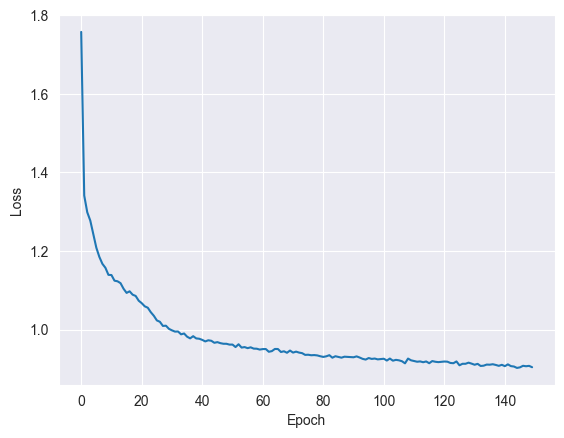

In [25]:
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [26]:
# Evaluate the trained network.
#
# total = 0
# correct = 0
# with torch.no_grad():   # No need for keeping track of necessary changes to the gradient.
#   for data in test_dl:
#     X, y = data
#     output = model(X)
#     for idx, val in enumerate(output):
#       print(val, y[idx])
#       if val == y[idx]:
#         correct += 1
#       total += 1
#   print('Accuracy:', round((correct/total) * 100, 3), "%")

err = nn.MSELoss()
mse_err = []
with torch.no_grad():
  for data in test_dl:
    X, y = data
    output = model(X)
    for idx, val in enumerate(output):
        # print("pred:", val.item(), "truth:", y.unsqueeze(-1)[idx].item())
        loss = err(val, y.unsqueeze(-1)[idx])
        mse_err.append(loss.item())
#
err = nn.L1Loss()
l1_err = []
with torch.no_grad():
  for data in test_dl:
    X, y = data
    output = model(X)
    for idx, val in enumerate(output):
        print("pred:", val.item(), "truth:", y.unsqueeze(-1)[idx].item())
        loss = err(val, y.unsqueeze(-1)[idx])
        l1_err.append(loss.item())
#
#
err = nn.SmoothL1Loss()
smooth_l1_err = []
with torch.no_grad():
  for data in test_dl:
    X, y = data
    output = model(X)
    for idx, val in enumerate(output):
        # print("pred:", val.item(), "truth:", y.unsqueeze(-1)[idx].item())
        loss = err(val, y.unsqueeze(-1)[idx])
        smooth_l1_err.append(loss.item())

err = nn.MSELoss()
rmse_err = []
with torch.no_grad():
  for data in test_dl:
    X, y = data
    output = model(X)
    for idx, val in enumerate(output):
        # print("pred:", val.item(), "truth:", y.unsqueeze(-1)[idx].item())
        loss = torch.sqrt(err(val, y.unsqueeze(-1)[idx]))
        rmse_err.append(loss.item())


pred: 7.344264030456543 truth: 7.699999809265137
pred: 10.984338760375977 truth: 11.699999809265137
pred: 5.288819313049316 truth: 4.5
pred: 3.8217148780822754 truth: 3.700000047683716
pred: 7.839409828186035 truth: 8.100000381469727
pred: 25.64798355102539 truth: 29.8700008392334
pred: 9.686677932739258 truth: 10.100000381469727
pred: 5.037619590759277 truth: 5.300000190734863
pred: 14.136131286621094 truth: 15.300000190734863
pred: 9.07846450805664 truth: 11.699999809265137
pred: 8.839415550231934 truth: 11.699999809265137
pred: 7.068963050842285 truth: 6.900000095367432
pred: 11.252190589904785 truth: 14.5
pred: 5.189352035522461 truth: 4.900000095367432
pred: 7.373589515686035 truth: 7.300000190734863
pred: 12.868599891662598 truth: 14.899999618530273
pred: 14.841191291809082 truth: 15.300000190734863
pred: 4.912508487701416 truth: 5.300000190734863
pred: 4.957087516784668 truth: 5.699999809265137
pred: 7.080338478088379 truth: 6.900000095367432
pred: 3.685173988342285 truth: 4.5
p

In [27]:
print(rmse_err == l1_err)

True


1.452128416766723


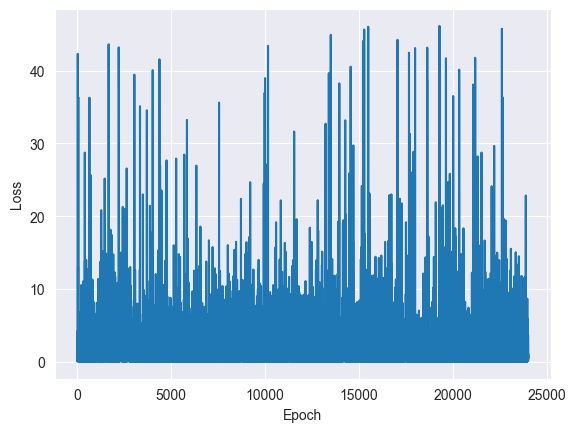

In [28]:
print(np.mean(l1_err))
plt.plot(range(len(l1_err)), l1_err)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

1.0620645268187614


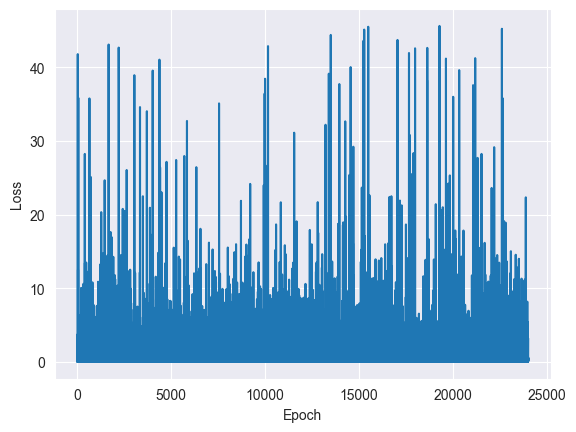

In [29]:
print(np.mean(smooth_l1_err))
plt.plot(range(len(smooth_l1_err)), smooth_l1_err)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

9.110459319085018


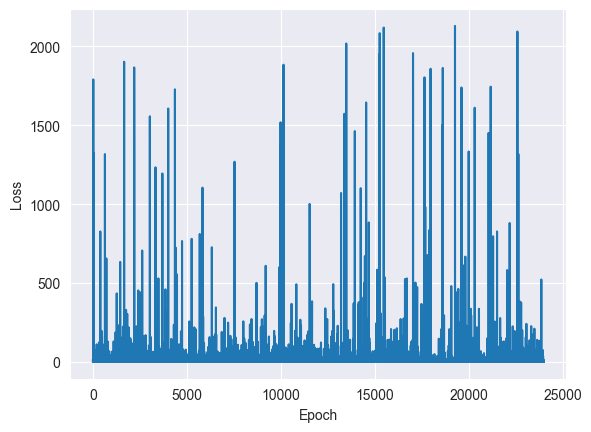

In [30]:
print(np.mean(mse_err))
plt.plot(range(len(mse_err)), mse_err)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

1.452128416766723


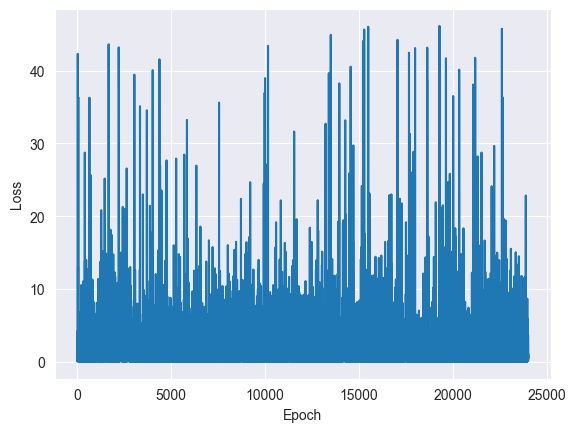

In [31]:
print(np.mean(rmse_err))
plt.plot(range(len(rmse_err)), rmse_err)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [32]:
#torch.save(model.state_dict(), "./models/model_9277.pt")